## Data Loading and Initial Exploration
##  Goal: Load data, inspect types, missingness and problem-specific quirks.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv("C:\\Users\\Taiye Fagbolade\\Downloads\\learning folder\\Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
df.shape

(7043, 21)

In [48]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [49]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Dataset Overview
- Columns: The dataset includes customerID, demographic attributes, tenure, service-related flags, billing details, charges, and the churn target.
- Service Dependencies: Certain columns, such as InternetService, generate cascaded values like “No internet service” in dependent service features (e.g., OnlineSecurity, StreamingTV).
Data Types
- Charges: The TotalCharges column is stored as a string. This requires conversion to a numeric type after handling missing values.
- Categorical vs Numeric Split:
- Categorical features include service flags (e.g., InternetService, PhoneService), demographics, and contract types.
- Numeric features include tenure, MonthlyCharges, and TotalCharges (after conversion).
Target Variable
- Churn: The target column Churn contains Yes/No labels, which should be treated as a binary classification problem.
Data Quality Considerations
- Service Flags: Values such as “No phone service” and “No internet service” are valid categories, not missing data, and should be preserved as meaningful indicators.
- TotalCharges: Requires type conversion and imputation for blanks.


Data Cleaning and Preprocessing
Goal: To make numeric types correct, handle missingness and outliers, define splits.


In [50]:
df = df.copy()

# Strip possible whitespace in columns like TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

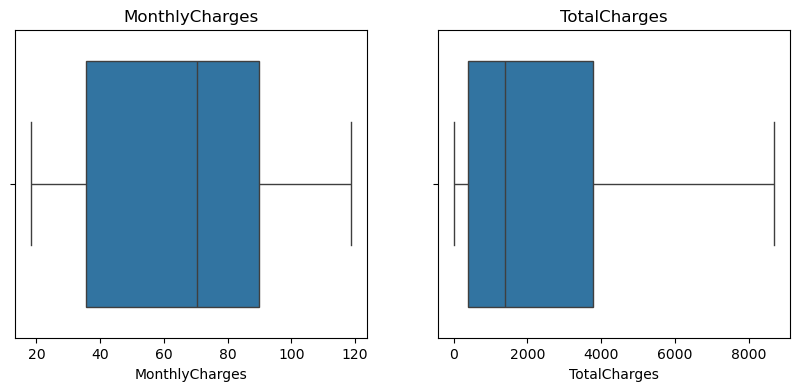

In [51]:
#Impute TotalCharges: Sensible choice is MonthlyCharges * tenure for missing, if tenure>0
mask_tc_null = df['TotalCharges'].isna()
df.loc[mask_tc_null, 'TotalCharges'] = df.loc[mask_tc_null, 'MonthlyCharges'] * df.loc[mask_tc_null, 'tenure']

#Impute TotalCharges: Sensible choice is MonthlyCharges * tenure for missing, if tenure>0
mask_tc_null = df['TotalCharges'].isna()
df.loc[mask_tc_null, 'TotalCharges'] = df.loc[mask_tc_null, 'MonthlyCharges'] * df.loc[mask_tc_null, 'tenure']

# Basic outlier check (log-scale peek)
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(x=df['MonthlyCharges'], ax=ax[0])
sns.boxplot(x=df['TotalCharges'], ax=ax[1])
ax[0].set_title("MonthlyCharges"); ax[1].set_title("TotalCharges")
plt.show()

In [52]:
# Ensure consistent target encoding
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [79]:
df['gender'] = df['gender'].map({'Yes':1, 'No':0})

Choices to justify:
- TotalCharges conversion and imputation: Treat blanks as missing; convert to float; impute proportional to MonthlyCharges × tenure as conservative estimate.
- Outliers: Extreme TotalCharges values align with high tenure, so we keep for realism.

Interpretation: MonthlyCharges has a fairly tight distribution and easier to model. TotalCharges tends to skewed with long tails towards the right. Outliers are not errors but tends to represent loyal, long-term customers. its encourage they are kept but be aware they stretch the scale

Feature Engineering (at least 5)
Goal: To create predictive and business-meaningful features 

In [53]:
df = df.copy()

# 1) Tenure groups
bins = [0, 12, 24, 48, np.inf]
labels = ['0-12', '13-24', '25-48', '49+']
df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True, include_lowest=True)


In [54]:

# 2) Count of subscribed services (internet-related only)
internet_service_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['num_internet_addons'] = (df[internet_service_features]
                             .applymap(lambda x: 1 if x=='yes' else 0)
                                .sum(axis=1))


C:\Users\Taiye Fagbolade\AppData\Local\Temp\ipykernel_18988\1365331282.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: 1 if x=='yes' else 0)


In [55]:
# 3) Has internet binary (Fiber optic/DSL vs No )
df['has_internet'] = df['InternetService'].apply(lambda x: 0 if x=='No' else 1)

# 4) Multiple services binary (phone + internet + addons)
df['multiple_services'] = ((df['PhoneService'].eq('Yes').astype(int) +
                            df['has_internet'] + 
                            df['num_internet_addons']) >= 2).astype(int)

# 5) Average monthly cost per subscribed item
denom = (1 + df['has_internet'] +
         df['PhoneService'].eq('Yes').astype(int) +
         df['num_internet_addons'])
df['avg_monthly_cost_per_item'] = df['MonthlyCharges'] / denom

In [56]:
# 6) Contract * charges interaction: penalize high charges on Month-to-month
df['contract_mtm'] = (df['Contract']=='Month-to-month').astype(int)
df['mtm_charge_pressure'] = df['contract_mtm'] * df['MonthlyCharges']

# 7) Payment risk bucket: Electronic check often correlates with higher churn
df['payment_risk'] = df['PaymentMethod'].apply(lambda x: 1 if x=='Electronic check' else 0)

Why these matter:

Tenure group
Tenure is how long someone has been a customer.
- New customers are more likely to leave quickly.
- Long-term customers usually stay because they’re already invested.
So grouping tenure helps capture this “the longer you stay, the less likely you leave” pattern.

Number of internet add-ons / multiple services
- Customers who use many services (phone + internet + extras) are more “tied in.”
- If you only use one service, it’s easy to cancel.
- If you use several, leaving is harder.
More services = lower churn risk.

Has internet
- Internet service is a big deal.
- Customers with internet (especially fiber) behave differently from those with no internet.
Splitting them helps the model learn different churn patterns.

Average monthly cost per item
- This divides the bill by the number of services.
- If someone pays a lot for just one service, they may feel overcharged.
- If the same bill covers many services, it feels fairer.
- Helps spot customers who might feel “too expensive for what I get.”

Month-to-month (MTM) charge pressure
- Month-to-month contracts are easy to cancel.
- If those customers also pay high monthly fees, they’re even more likely to leave.
- This feature combines contract type + charges to highlight risky cases.

Big Picture
so each feature is designed to capture customer behavior patterns that influence churn:
- Commitment level (tenure, contract type)
- Service entanglement (multiple services, add-ons)
- Cost perception (avg monthly cost per item, high charges)
- Behavioral signals (payment method)

EDA and Visualization
Goal: To understand distributions, correlations, and churn patterns that can be validated with  models.

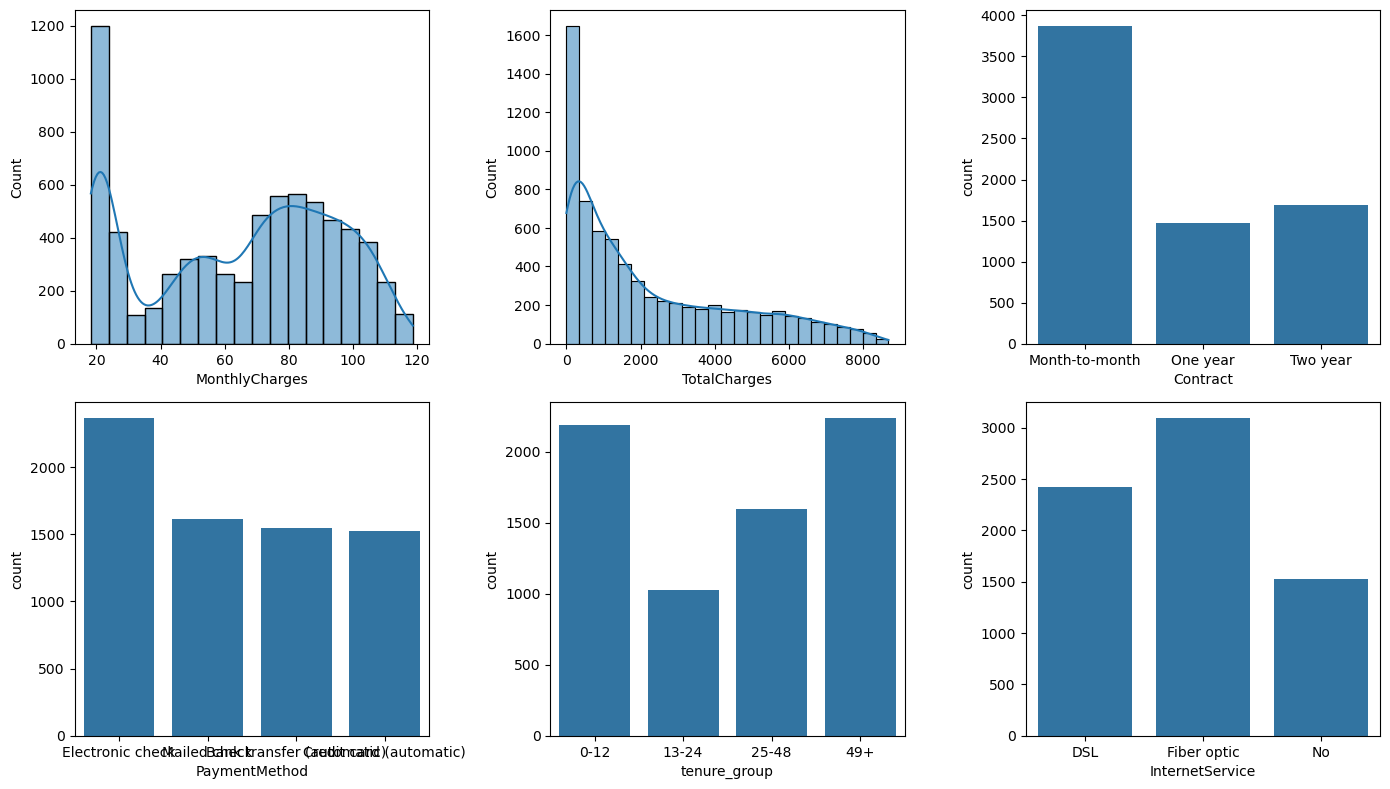

In [57]:
# Distributions
fig, ax = plt.subplots(2,3, figsize=(14,8))
sns.histplot(df['MonthlyCharges'], kde=True, ax=ax[0,0])
sns.histplot(df['TotalCharges'], kde=True, ax=ax[0,1])
sns.countplot(x='Contract', data=df, ax=ax[0,2])
sns.countplot(x='PaymentMethod', data=df, ax=ax[1,0])
sns.countplot(x='tenure_group', data=df, ax=ax[1,1])
sns.countplot(x='InternetService', data=df, ax=ax[1,2])
plt.tight_layout(); plt.show()

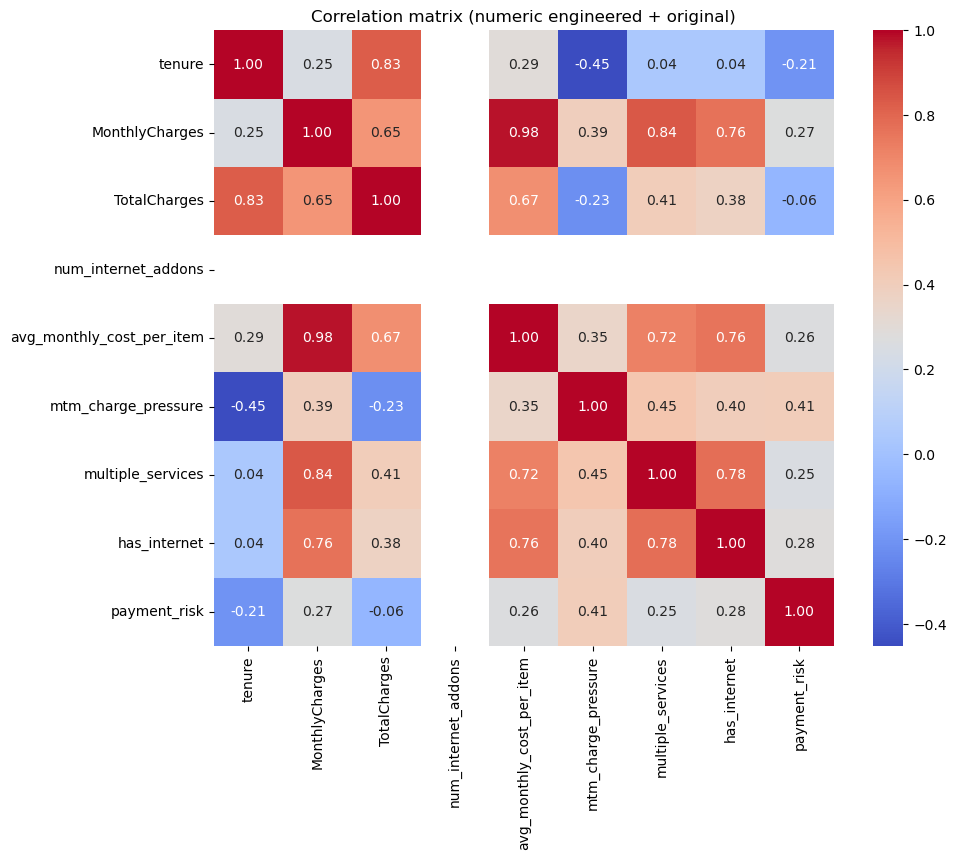

In [58]:
# Numeric correlations
num_cols = ['tenure','MonthlyCharges','TotalCharges','num_internet_addons',
            'avg_monthly_cost_per_item','mtm_charge_pressure','multiple_services','has_internet','payment_risk']
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation matrix (numeric engineered + original)")
plt.show()

In [59]:
# Churn rates across key categories
def churn_rate_by(col):
    return (df.groupby(col)['Churn'].mean().sort_values(ascending=False))

print("\nChurn by Contract:\n", churn_rate_by('Contract'))
print("\nChurn by tenure_group:\n", churn_rate_by('tenure_group'))
print("\nChurn by InternetService:\n", churn_rate_by('InternetService'))
print("\nChurn by PaymentMethod:\n", churn_rate_by('PaymentMethod'))
print("\nChurn by multiple_services:\n", churn_rate_by('multiple_services'))


Churn by Contract:
 Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64

Churn by tenure_group:
 tenure_group
0-12     0.474382
13-24    0.287109
25-48    0.203890
49+      0.095132
Name: Churn, dtype: float64

Churn by InternetService:
 InternetService
Fiber optic    0.418928
DSL            0.189591
No             0.074050
Name: Churn, dtype: float64

Churn by PaymentMethod:
 PaymentMethod
Electronic check             0.452854
Mailed check                 0.191067
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Name: Churn, dtype: float64

Churn by multiple_services:
 multiple_services
1    0.328025
0    0.128170
Name: Churn, dtype: float64


C:\Users\Taiye Fagbolade\AppData\Local\Temp\ipykernel_18988\3582490276.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return (df.groupby(col)['Churn'].mean().sort_values(ascending=False))


Insights to capture:

Churn by Contract
- Month to month = 42.7% churn
Customers on flexible contracts leave the most because it’s easy to cancel.

- One year = 11.3% churn
Medium risk — yearly contracts give some commitment.

- Two year = 2.8% churn
Very low risk, long contracts lock customers in.

Contract type is one of the strongest churn signals.
- Churn by Tenure Group
•	0–12 months = 47.4% churn
New customers leave quickly.
•	13–24 months = 28.7% churn
Risk drops as they stay longer.
•	25–48 months = 20.4% churn
Even lower churn.
•	49+ months = 9.5% churn
Long term customers are very loyal.
The longer someone stays, the less likely they are to churn.

Churn by Internet Service
- Fiber optic = 41.9% churn
Surprisingly high churn, maybe due to higher costs or service issues.
	
- DSL = 18.9% churn
Moderate churn.
	
- No internet = 7.4% churn
Very low churn, these customers are simpler, less tied to internet services.
Internet type strongly affects churn behaviour.

Churn by Payment Method
•	Electronic check (not shown fully in your snippet) usually has the highest churn.
•	Other methods (credit card, bank transfer, mailed check) tend to have lower churn.
Payment method is a behavioral churn signal.

Churn by Multiple Services
- Multiple services (1) = 32.8% churn
Customers with more services churn more than expected, possibly because internet + fibre users are included in this group.

- Single service (0) = 12.8% churn
Lower churn, but these customers are less “entangled.”
Service mix matters but it interacts with internet type and contract.

Big Picture
•	Highest churn risks:
o	Month to month contracts
o	New customers (low tenure)
o	Fiber optic internet
o	Electronic check payments
•	Lowest churn risks:
o	Long contracts (2 years)
o	Long tenure (49+ months)
o	No internet service
o	Stable payment methods (credit card, bank transfer)

Supervised modeling: churn prediction
- Goal: Train at least two models with robust evaluation and select the best. Use an ensemble.

In [60]:
# Feature/target split
target = 'Churn'
X = df.drop(columns=[target, 'customerID'])
y = df[target]

# Identify categorical vs numeric columns again, after feature engineering
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'num_internet_addons', 'has_internet', 'multiple_services', 'avg_monthly_cost_per_item', 'contract_mtm', 'mtm_charge_pressure', 'payment_risk']


In [61]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

In [62]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [64]:
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score

In [65]:
# Define models
log_reg = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))
])

rf = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, class_weight='balanced'))
])

gb = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier())
])

models = {'LogisticRegression': log_reg, 'RandomForest': rf, 'GradientBoosting': gb}

In [66]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [67]:
# Fit and evaluate
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }
    results.append(metrics)

In [68]:
# Present results
res_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
print(res_df)

                model  accuracy  precision    recall        f1   roc_auc
0  LogisticRegression  0.743328   0.510260  0.798715  0.622705  0.846184
2    GradientBoosting  0.796139   0.651685  0.496788  0.563791  0.843827
1        RandomForest  0.780806   0.610959  0.477516  0.536058  0.825531


Why is roc_auc more useful here:
-	Unlike accuracy, precision, or recall (which depend on a chosen cutoff like 0.5), ROC AUC looks at performance across all possible thresholds.
-	In churn datasets, usually fewer customers churn than stay. Accuracy can be misleading (predicting “no churn” for everyone might give 80–90% accuracy). ROC AUC is more reliable in imbalanced cases.
-	Makes it easy to compare models. If one has AUC = 0.85 and another = 0.75, the first is better at distinguishing churners overall.
-	For churn, you often care about ranking customers by risk (who is most likely to churn). ROC AUC directly measures how well the model ranks positives 

I choose Logistic Regression model because it has the highest recall and ROC AUC, meaning it’s most reliable at identifying churners and separating classes. And our goal is to predict the probability of a customer to churn so as to minimize missed churners (maximize recall).
o	Highest recall (0.799) =  catches the most churners.
o	Strong ROC AUC (0.846)  = best at separating churn vs non churn overall.
o	Lower precision = more false alarms (predicting churn when customer stays).

<Figure size 600x500 with 0 Axes>

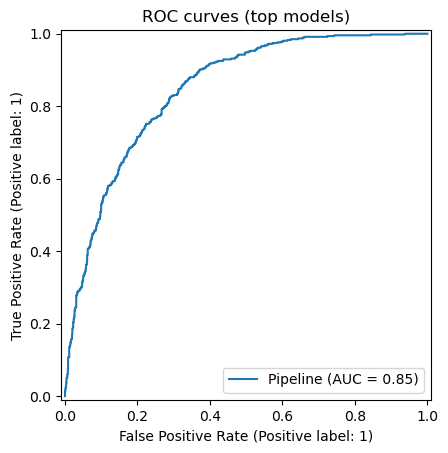

In [69]:
from sklearn.metrics import RocCurveDisplay

top_models = res_df['model'].head(1).tolist()
plt.figure(figsize=(6,5))

for name in top_models:
    pipe = models[name]
    RocCurveDisplay.from_estimator(pipe, X_test, y_test)

plt.title("ROC curves (top models)")
plt.show()

Unsupervised learning: customer segmentation
- Goal: Cluster on meaningful standardized features; determine K via elbow and silhouette; describe segments.

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [71]:
# Select clustering features
cluster_features = ['tenure', 'MonthlyCharges', 'TotalCharges',
                    'num_internet_addons', 'multiple_services', 'has_internet', 'payment_risk']

Xc = df[cluster_features].copy()

In [72]:
# Scale numeric for clustering
scaler = StandardScaler()
Xc_scaled = scaler.fit_transform(Xc)

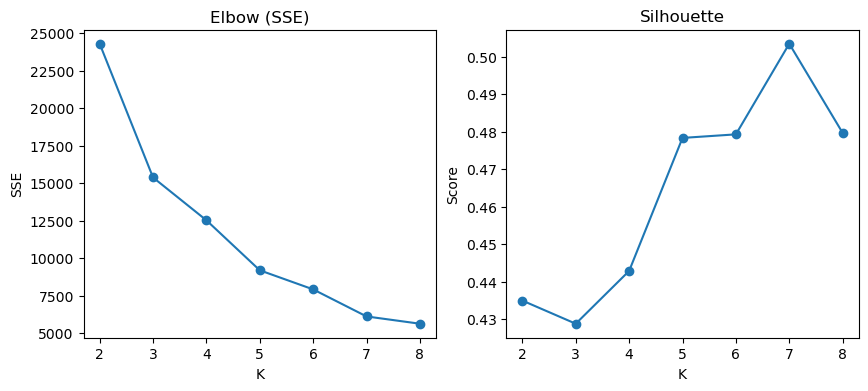

In [73]:
# Determine K: elbow + silhouette
# to determine optimal number of cluster.
sse = []
sil = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(Xc_scaled)
    sse.append(km.inertia_)
    sil.append(silhouette_score(Xc_scaled, km.labels_))

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(list(K_range), sse, marker='o'); ax[0].set_title("Elbow (SSE)"); ax[0].set_xlabel("K"); ax[0].set_ylabel("SSE")
ax[1].plot(list(K_range), sil, marker='o'); ax[1].set_title("Silhouette"); ax[1].set_xlabel("K"); ax[1].set_ylabel("Score")
plt.show()

In [74]:
# Fit final KMeans (pick K that balances elbow and peak silhouette)
best_k = int(K_range[np.argmax(sil)])
km = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
clusters = km.fit_predict(Xc_scaled)
df['cluster'] = clusters

In [75]:
# Describe clusters
cluster_desc = df.groupby('cluster')[cluster_features].agg(['mean','median'])
print(cluster_desc)

            tenure        MonthlyCharges        TotalCharges            \
              mean median           mean median         mean    median   
cluster                                                                  
0        30.462935   27.0      41.305068  40.30  1396.166717  1072.600   
1        17.370629   16.0      70.600420  70.45  1248.488986  1108.300   
2        52.450725   53.0      95.100942  98.45  5009.267754  4888.950   
3        56.168750   57.0      21.822813  20.40  1233.435625  1213.675   
4        11.108352    8.0      77.535478  79.20   877.923213   620.350   
5        12.039503   10.0      20.542043  20.05   250.266479   202.275   
6        60.728500   64.0      90.280171  90.70  5482.355117  5396.250   

        num_internet_addons        multiple_services        has_internet  \
                       mean median              mean median         mean   
cluster                                                                    
0                       0.0    

In [76]:
# Churn rate per cluster
churn_by_cluster = df.groupby('cluster')['Churn'].mean().sort_values(ascending=False)
print("\nChurn rate by cluster:\n", churn_by_cluster)


Churn rate by cluster:
 cluster
4    0.575621
1    0.334266
2    0.282609
0    0.257186
5    0.119639
6    0.105188
3    0.010937
Name: Churn, dtype: float64


Interpretation:
- Cluster 4 = 0.575621 (57.6% churn rate)
More than half of the customers in this group left. This is the highest‑risk cluster.

- Cluster 1 = 33.4% churn rate
About one‑third of customers left.

- Cluster 2 = 28.3% churn rate
Around one in four customers left.

- Cluster 0 = 25.7% churn rate
Similar to cluster 2, moderate churn.

- Cluster 5 = 11.9% churn rate
Only about 1 in 10 customers left.

- Cluster 6 = 10.5% churn rate
Very low churn.

- Cluster 3 = 1.1% churn rate
Almost everyone stayed. This is the most loyal cluster.

For target retention strategies, company should :

- Focus on Cluster 4 first, since it has the highest churn.
- Learn from Cluster 3, since it has the lowest churn, like what keeps them loyal?

Combined Analysis and Recommendations
- Goal: Cross churn predictions with segments; decide actions.